# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [7]:
%%capture
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
!pip install transformers

import lucem_illud

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
import io

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

In [3]:
%matplotlib inline

In [6]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [9]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [11]:
%%capture
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

In [12]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [13]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [ ]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

In [ ]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [ ]:
# This is a Reddit thread
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.Cornell',
 'gilded': 0,
 'gildings': None,
 'num_comments': 2,
 'stickied': False,
 'subreddit': 'Cornell',
 'timestamp': 1487589617,
 'title': 'Free and well trusted Internet dating website with a lot of girls. My real story about 3 times with different girls for guys'}

In [ ]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': None,
 'permalink': '/r/Cornell/comments/937pyg/does_bethe_house_dorm_receive_mail_packages_this/e3cx8gt/',
 'retrieved_on': 1536928999,
 'score': 1,
 'stickied': False,
 'subreddit': 'Cornell',
 'top_level_comment': 'e3bnal2'}

In [ ]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {'character_name': 'DOMINO', 'movie_idx': 'm325', 'movie_name': 'domino', 'gender': 'f', 'credit_pos': '1'}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fed3c441890>, 'id': 'u4874'})

In [ ]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'What gyms on campus have weight machines?', 'num_comments': 2, 'domain': 'self.Cornell', 'timestamp': 1471996637, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fed3c6c9ad0>, 'id': '4z9lds'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Conversations of death?', 'num_comments': 11, 'domain': 'self.Cornell', 'timestamp': 1488511204, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fed3c6c9ad0>, 'id': '5x80o4'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Best Freshman Dorms? (SHA)', 'num_comments': 14, 'domain': 'self.Cornell', 'timestamp': 1488849562, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'au

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

I've seen lots of people.  It's not a big thing for me.

    Hand me a towel.  I'm getting out.

        I'm coming in.

            I don't want you to!

                We're not gonna do anything.

                    Why are you so stupid?

                        Why are you so uptight?

                            I don't even...what do you mean?  I don't even know what that means.

                                It means I'm gonna shampoo my hair and stay out of your way.

                                    Hand me a towel.  Hand me a towel.



There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [69]:
from convokit import FightingWords, TextCleaner

In [70]:
corpus = Corpus(filename=download("friends-corpus"))

In [71]:
corpus.print_summary_stats()

Number of Speakers: 700
Number of Utterances: 67373
Number of Conversations: 3107


In [72]:
corpus.random_conversation().meta

{'episode': 'e21', 'scene': 'c13', 'season': 's02'}

In [73]:
corpus.random_utterance().meta

{'caption': None,
 'character_entities': None,
 'emotion': None,
 'tokens': [['No', '!'],
  ['What', 'are', 'you', 'going', 'to', 'do', '?'],
  ['Make', 'me', '?']],
 'tokens_with_note': None,
 'transcript_with_note': None}

In [74]:
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

There's nothing to tell! He's just some guy I work with!


In [75]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'season': 's02', 'episode': 'e03', 'scene': 'c02'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f74d8d8a450>, 'id': 's02_e03_c02_u001'}),
 Conversation({'obj_type': 'conversation', 'meta': {'season': 's02', 'episode': 'e03', 'scene': 'c03'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f74d8d8a450>, 'id': 's02_e03_c03_u001'}),
 Conversation({'obj_type': 'conversation', 'meta': {'season': 's02', 'episode': 'e09', 'scene': 'c09'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f74d8d8a450>, 'id': 's02_e09_c09_u001'})]

In [76]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")



    So you didn't leave the bank?

        No! And somehow, we ended up with a joint checking account.

            What are you ever gonna use that for?!

                To pay for the gym.

                    

                        Hey.

                            Hey! So I had a great day, Rick and I really hit it off, and we started making o

                                What?!

                                    You got fired?!

                                        Oh my Gosh!

                                            It's so weird, I have never been fired from anything before!

                                                Sweety...

                                                    I just-I just started walking around not knowing what to do next, y'know? I-I st

                                                        

                                                            Hey Duck, is Chick here?

                                                      

In [77]:
TextCleaner(verbosity=50000).transform(corpus)

50000/67373 utterances processed
67373/67373 utterances processed


In [78]:
for convo in corpus.iter_conversations():
    speakers = [speaker.id for speaker in convo.iter_speakers()]
    convo.meta['CB'] = 'Chandler Bing'in speakers

In [79]:
cnt_CB = 0
cnt_convo = 0
for convo in corpus.iter_conversations():
    cnt_CB += convo.meta['CB']
    cnt_convo +=1

In [80]:
print(f"Chandler appears in {cnt_CB/cnt_convo} of the conversations.")

Chandler appears in 0.48696491792726104 of the conversations.


Initializing default CountVectorizer with ngram_range (1, 6)... Done.
class1_func returned 39108 valid corpus components. class2_func returned 28265 valid corpus components.
Vocab size is 13356
Comparing language...
ngram zscores computed.


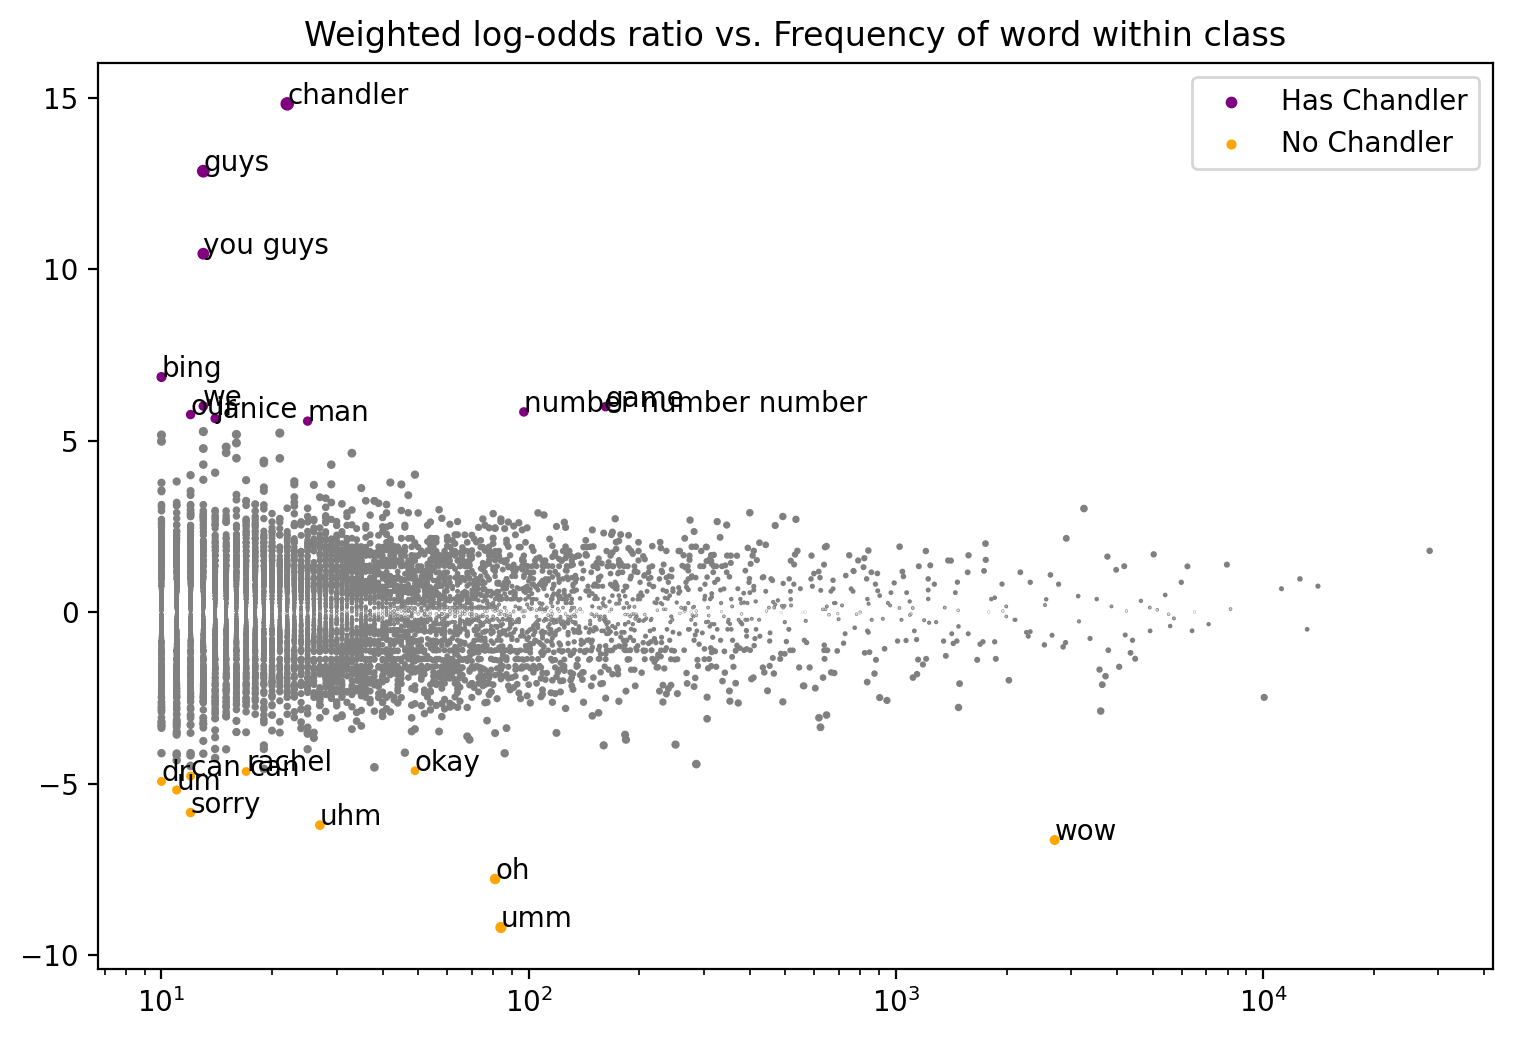

,z-score,class
ngram,,
umm,-9.184526,No Chandler
oh,-7.771805,No Chandler
wow,-6.636275,No Chandler
uhm,-6.202341,No Chandler
sorry,-5.835718,No Chandler
...,...,...
we,6.009986,Has Chandler
bing,6.856473,Has Chandler
you guys,10.449229,Has Chandler


In [81]:
fw = FightingWords(ngram_range=(1,6))

fw.fit(corpus, class1_func=lambda utt: utt.get_conversation().meta['CB'],
       class2_func=lambda utt: not utt.get_conversation().meta['CB'])

fw.summarize(corpus, plot=True, class1_name='Has Chandler', class2_name='No Chandler')

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

ValueError: ignored

In [ ]:
df_meta_info = pd.read_table('meta-info.txt',header=None)
df_log_prob = pd.read_csv("SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv('SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv('cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

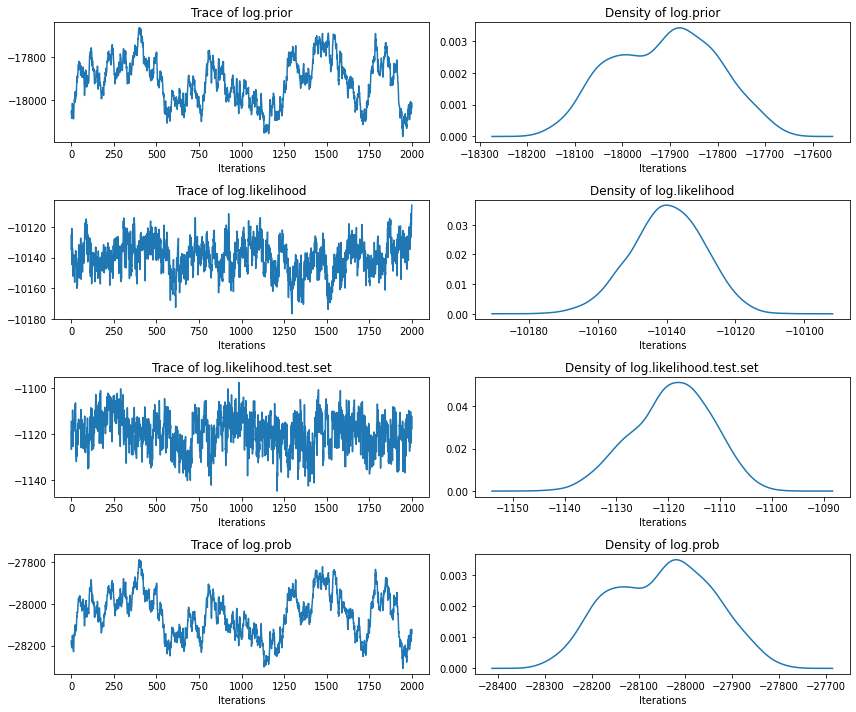

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


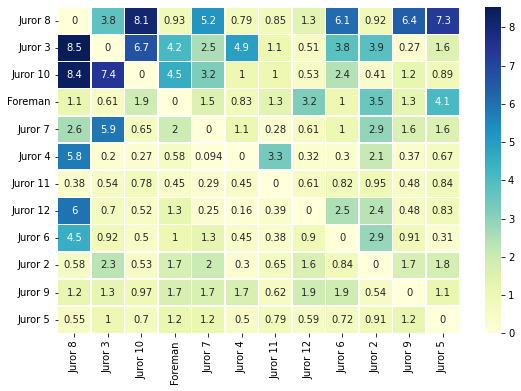

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


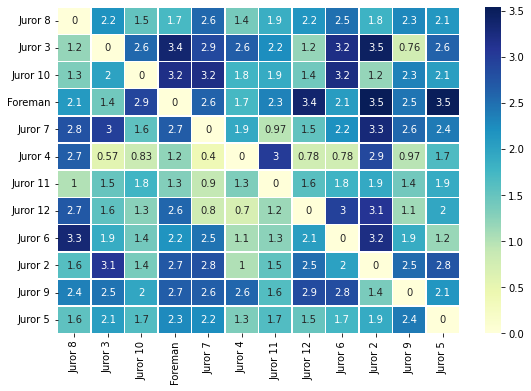

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Ford,"[iscg, ashs, cfld, hdda, gibl, gish, sebe, gbs...",0.805929,1.529656
1,Bush,"[ksgc, ldia, alie, bcfj, scgb, icla, skes, kaa...",2.154775,3.573448


Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In this exercise, I will conduct network analysis on the soap opera Passion. 

In [19]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [23]:
!unzip "/content/drive/MyDrive/Colab Notebooks/SOAP.zip" -d /content/soap

Archive:  /content/drive/MyDrive/Colab Notebooks/SOAP.zip
 extracting: /content/soap/soap_sources.zip  
 extracting: /content/soap/text_0-tez.zip  
 extracting: /content/soap/text_1-teh.zip  
 extracting: /content/soap/text_2-wts.zip  
 extracting: /content/soap/text_3-pem.zip  
 extracting: /content/soap/text_4-jfy.zip  
 extracting: /content/soap/text_5-rag.zip  
 extracting: /content/soap/text_6-egn.zip  
 extracting: /content/soap/text_7-jss.zip  
 extracting: /content/soap/text_8-sbo.zip  
 extracting: /content/soap/text_9-jtw.zip  


In [24]:
corpora_address = "/content/soap"

In [25]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_8-sbo.zip
text_1-teh.zip
text_4-jfy.zip
text_9-jtw.zip
text_3-pem.zip
text_2-wts.zip
text_0-tez.zip
text_5-rag.zip


In [28]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [31]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [32]:
soap_dict = {}
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [33]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [34]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
i = 0
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [35]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


In [36]:
passion = soap_df['Tokenized Texts'][7]

In [42]:
passion[:10]

['@!Julian', 'Let', "'s", 'drink', 'up', 'It', "'s", 'not', 'every', 'day']

In [37]:
' '.join(passion[0:1500])

"@!Julian Let 's drink up It 's not every day such a beautiful young couple gets engaged It 's a cause for celebration @!Rebecca Not to mention the fact that Alistair and Julian are going to throw you a party that will be filled with excitement @!Luis I do n't know what 's going on here but I 'm not trusting Rebecca or Julian And how the hell did Alistair know that we 'd gotten engaged It 's not like I called him to ask for your hand in marriage @!Sheridan I do n't know I do think it 's kind of nice though that you know my father and brother want to throw us a party Maybe they finally accepted us as being a couple @!Luis Alistair and Julian Sheridan there 's no way They 're up to something @!Sheridan I 'm afraid you 're probably right @!Rebecca I do n't thing they 're buying this one bit @!Julian They better to start buying it Father ordered us to make sure that they come romance forever @!Rebecca Yes but the plan is perfectly in place I mean at the party Sheridan is going to get her l

In [38]:
characters = {}
for token in passion:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [56]:
for character in characters:
    if characters[character] > 1500:
        print(character, characters[character])

Luis 2620
Sheridan 2010
Theresa 3106
Whitney 1780
Ethan 2139
Kay 1655


In [62]:
actor_network = nx.Graph()

In [63]:
for character in characters:
    if characters[character] > 1500:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [64]:
len(actor_network.nodes.data())

6

In [65]:
actor_network.nodes['Luis']['lines_spoken']

2620

In [66]:
i = 0
for token in passion:
    i += 1
    if i > len(passion):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in passion[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(passion[i:j])

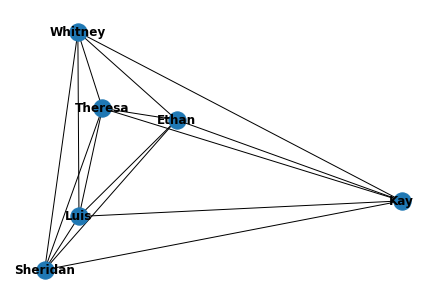

In [67]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [53]:
import seaborn as sns

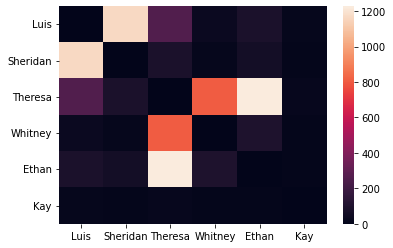

In [68]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

From the heatmap above, we can see that Sheridan and Luis, Ethan and Theresa, as well as Whitney and Theresa have particular frequent conversations. This is unsuprising as Sheridan and Luis as well as Ethan and Theresa are romantically invovled. Whitney and Theresa are bests friends. It is interesting, nontheless, that this soap opera's fictional relationships are rather concentrated. That is, it seems like only a pair of typically romantically involved couple are communicating. There aren't much room for a thrid person. This contradict to show like Friends where you are expected to seem a group in conversations with another. From a sociological perspective, this observation is interesting as the shows perfectly demonstrate the stereotypical image of love - hetereosexua, obsessive and exclusive.

In [55]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))
c

[frozenset({'Ethan', 'Luis', 'Sheridan', 'Theresa'})]

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [ ]:
dfs = []

In [ ]:
for file in os.listdir("../data/trump_tweets"):
    dfs.append(pd.read_json("../data/trump_tweets/" + file))

In [ ]:
df = pd.concat(dfs)

In [ ]:
df.head()

In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [ ]:
train_text.head()

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "C:/Downloads/GloWbE"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

NameError: ignored

In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal.

#### Trump GPT-2

In [ ]:
# You might have issues with the memory of your GPU in the following code.
# The default Google Colab GPU should work with batch size of 2,
# but if you get a "CUDA out of memory" error, you can reduce it to 1.
# The default is 4 if you have a large GPU.

# !python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
!python run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

#### RoBERTa US

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

#### RoBERTa UK

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_trump

In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a very good president," said Sen. John McCain (R-Ariz.). "He's going to be a very good president. He's going to be a very good president. He's going to be a very good


Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

 I fine-tune RoBERTa and GPT2 on my music lyric dataset with 236,085 songs between 1970 - 2020. I choose RoBERTa because it is trained without BERT’s next-sentence pretraining objective. However, RoBERTa failed to generate meaningful characters. GPT2 did a much better job, although still imperfect.

In the GPT models, for the untrained model, inputing “She is such a bitch” returns “She’s so fucking hot”, indicating that “bitch” when describing women is referring to sexualized or physical attractiveness. In the trained model “She is such a bitch” returns “I’m so tired of her”, indicating bitch has the negatively connotation of being annoying. One the other hand, “He is such a bitch” returns “I’m so scared of you.”, indicating that when referring to a male as a bitch, it carries a sense of intimidations. The trained model also associate girl with beautiful and boy is good, again demonstrating an emphasis of physical attributes for woman in popular music lyrics. The untrained model does not have such gendered divide and return “good” for both “That boy is” and “That girl is”.

In [ ]:
lyrics = pd.read_csv("sp_bb_metro_matched.csv")

In [ ]:
samp = lyrics.sample(10000, random_state = 7)

In [ ]:
samp.year_bin.value_counts()

2000s    6528
2010s    2858
1990s     353
1980s     141
1970s     120
Name: year_bin, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(samp['lyrics'], test_size=0.2)

In [ ]:
train_text

66700      Ft Freddie Gibbs Ha ha ha ha Hard as they com...
86937     She had an horror of rooms she was tired you c...
129810    Verse1 Though my heart and flesh may fail And ...
181704    Won't you look inside and see what's inside a ...
16960     Ciara:\nMy goodies, my goodies\nMy goodies not...
                                ...                        
58621     I took out a loan on my empty heart babe I too...
221584    Make up your mind Ignore your senses Leave us ...
45173     A communist invasion to force occupation A run...
159243    Exhume the rotted casket Robbing graves But no...
110306    Give thanks with a grateful heart Give thanks ...
Name: lyrics, Length: 8000, dtype: object

In [ ]:
train_text.to_frame().to_csv(r'train_text_lyrics', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_lyrics', header=None, index=None, sep=' ', mode='a')

### RoBERTa

In [ ]:
!python /content/run_language_modelling.py --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_lyrics --do_eval --eval_data_file=test_text_lyrics --mlm --per_gpu_train_batch_size=10

03/03/2022 18:29:10 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
Downloading: 100% 481/481 [00:00<00:00, 620kB/s]
Downloading: 100% 878k/878k [00:00<00:00, 2.39MB/s]
Downloading: 100% 446k/446k [00:00<00:00, 1.46MB/s]
Downloading: 100% 478M/478M [00:07<00:00, 70.6MB/s]
03/03/2022 18:29:33 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=512, cache_dir=None, config_name=None, device=device(type='cuda'), do_eval=True, do_train=True, eval_all_checkpoints=False, eval_data_file='test_text_lyrics', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, line_by_line=False, local_rank=-1, logging_steps=500, max_grad_norm=1.0, max_steps=-1, mlm=True, mlm_probability=0.15, model_name_or_path='roberta-base', model_type='roberta', n_gpu=1, no_cuda=False, num_train_epochs=1.0, output_dir='output_roberta_us', overwrite_c

In [ ]:
!zip -r /content/drive/MyDrive/file.zip  /content/output_roberta_us

  adding: content/output_roberta_us/ (stored 0%)
  adding: content/output_roberta_us/checkpoint-8500/ (stored 0%)
  adding: content/output_roberta_us/checkpoint-8500/config.json (deflated 50%)
  adding: content/output_roberta_us/checkpoint-8500/merges.txt (deflated 53%)
  adding: content/output_roberta_us/checkpoint-8500/training_args.bin (deflated 44%)
  adding: content/output_roberta_us/checkpoint-8500/scheduler.pt (deflated 49%)
  adding: content/output_roberta_us/checkpoint-8500/vocab.json (deflated 63%)
  adding: content/output_roberta_us/checkpoint-8500/special_tokens_map.json (deflated 83%)
  adding: content/output_roberta_us/checkpoint-8500/optimizer.pt (deflated 8%)
  adding: content/output_roberta_us/checkpoint-8500/tokenizer_config.json (deflated 72%)
  adding: content/output_roberta_us/checkpoint-8500/pytorch_model.bin (deflated 7%)
  adding: content/output_roberta_us/checkpoint-9500/ (stored 0%)
  adding: content/output_roberta_us/checkpoint-9500/config.json (deflated 50%)

In [ ]:
tokenizer_lyrics = AutoTokenizer.from_pretrained("/content/output_roberta_us")
model_lyrics = AutoModelWithLMHead.from_pretrained("/content/output_roberta_us")

In [ ]:
sequence = "He is so"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

He is so much more than a guy who is a guy who is a guy who is a guy who is a guy who is a guy who is a guy who is a guy who is a guy who is a guy who is a guy who is


In [ ]:
sequence = "I"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

<s>I</s></s>


In [ ]:
sequence = "Love"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

<s>Love</s></s>


In [ ]:
sequence = "He is a bitch so"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

He is a bitch so I'm not going to tell you what I think. I'm not going to tell you what I think. I'm not going to tell you what I think. I'm not going to tell you what I think. I


In [ ]:
sequence = "He is a bitch"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

<s>He is a bitch</s></s>


In [ ]:
sequence = "She is a bitch so"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

She is a bitch so I'm going to take her to the hospital. I'm going to take her to the hospital. I'm going to take her to the hospital. I'm going to take her to the hospital. I'm going to take


In [ ]:
sequence = "She is a bitch so"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

<s>She is a bitch so</s></s>


In [ ]:
sequence = "Bitch is a"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

<s>Bitch is a</s>
 liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar liar


In [ ]:
sequence = "Bitch is a"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Bitch is a very good player. He's a very good player. He's a very good player. He's a very good player. He's a very good player. He's a very good player. He's a very good player.


In [ ]:
sequence = "That bitch is"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

<s>That bitch is</s></s>


### GPT2

In [ ]:
train_text, test_text = train_test_split(lyrics['lyrics'], test_size=0.2)
train_text.to_frame().to_csv(r'train_text_lyrics', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_lyrics', header=None, index=None, sep=' ', mode='a')

In [ ]:
len(lyrics['lyrics'])

236085

In [ ]:
test_text[100]

"Straight west coast flava Um, 1994 Nuttin' Nyce is in the house Bring it to me! Hotel Motel Holiday Inn Whateva you want I got it Whateva you need I got it Reach in my backpack And pick you out a condom Ain`t got no love For those who won't wear them Really No so All I wanna know is do you want me? (Someone to play with) Down 4 whateva Be it night or day (Someone to play with) Tell me what you need And I'll make it happen (Someone to play with) Whateva it is I'll be there right away (Someone to play with) Set it off with the strip Up to Strawberry Hill Then hit the chronic You know i feel so by.i.onic Damn it! And I exhale you like to get deep So deep Now you meet the freak of the week, so All I wanna know is do you want me? (Someone to play with) Down 4 whateva Be it night or day (Someone to play with) Tell me what you need And I'll make it happen (Someone to play with) Whateva it is I'll be there right away (Someone to play with) Oh! It`s a shame what you do to me Let me see you wor

In [ ]:
!python /content/run_language_modelling.py --output_dir=output_gpt_lyrics --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_lyrics --do_eval --eval_data_file=test_text_lyrics --per_gpu_train_batch_size=2 --overwrite_output_dir

03/03/2022 21:48:41 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/03/2022 21:48:48 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir=None, config_name=None, device=device(type='cuda'), do_eval=True, do_train=True, eval_all_checkpoints=False, eval_data_file='test_text_lyrics', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, line_by_line=False, local_rank=-1, logging_steps=500, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, output_dir='output_gpt_lyrics', overwrite_cache=False, overwrite_output_dir=True, per_gpu_eval_batch_size=4, per_gpu_train_batch_size=2, save_steps=500, save_total_limit=None, seed=42, server_ip='', server_port='', should_continue=False, tokenizer_name=None

In [ ]:
tokenizer_lyrics = AutoTokenizer.from_pretrained("/content/output_gpt_lyrics")
model_lyrics = AutoModelWithLMHead.from_pretrained("/content/output_gpt_lyrics")
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt= AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
sequence = "She is such a bitch"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

She is such a bitch I'm so tired of her I'm so tired of her I'm so tired of her I'm so tired of her I'm so tired of her I'm so tired of her I'm so tired of her I'm so


In [ ]:
sequence = "She is such a bitch"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

She is such a bitch. She's so fucking hot. She's so fucking hot. She's so fucking hot. She's so fucking hot. She's so fucking hot. She's so fucking hot. She's so fucking hot. She's


In [ ]:
sequence = "He is such a bitch"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

He is such a bitch I'm so scared of you I'm so scared of you I'm so scared of you I'm so scared of you I'm so scared of you I'm so scared of you I'm so scared of you I'm so


In [ ]:
sequence = "He is such a bitch"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

He is such a bitch. I'm not going to let her get away with it. I'm not going to let her get away with it. I'm not going to let her get away with it. I'm not going to let her get


In [ ]:
sequence = "That girl is"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

That girl is so beautiful I can't believe I'm so alone I can't believe I'm so alone I can't believe I'm so alone I can't believe I'm so alone I can't believe I'm so alone I can't believe I


In [ ]:
sequence = "That girl is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

That girl is a good girl. She's a good girl. She's a good girl. She's a good girl. She's a good girl. She's a good girl. She's a good girl. She's a good girl. She


In [ ]:
sequence = "That boy is"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

That boy is so good I can't believe he's still here I'm so glad I found him I'm so glad I found him I'm so glad I found him I'm so glad I found him I'm so glad I found him I'm


In [ ]:
sequence = "That boy is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

That boy is a good kid. He's a good kid. He's a good kid. He's a good kid. He's a good kid. He's a good kid. He's a good kid. He's a good kid. He


In [ ]:
sequence = "Women are very"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

Women are very much like us We're not the same We're not the same We're not the same We're not the same We're not the same We're not the same We're not the same We're not the same We're not the


In [ ]:
sequence = "Women are very"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Women are very much in the minority in the United States.

The number of women in the workforce has increased by more than 50 percent since the mid-1990s.

The number of women in the workforce has increased by more than 50


In [ ]:
sequence = "Men are very"

input = tokenizer_lyrics.encode(sequence, return_tensors="pt")
generated = model_lyrics.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_lyrics.decode(generated.tolist()[0])
print(resulting_string)

Men are very good at it And they're very good at it And they're very good at it And they're very good at it And they're very good at it And they're very good at it And they're very good at it And they


In [ ]:
sequence = "Men are very"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Men are very good at it. They're very good at it. They're very good at it. They're very good at it. They're very good at it. They're very good at it. They're very good at it. They


Trained GPT2 model disclose interesting patterns in the lyrical data.

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [ ]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [ ]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

I think it would be interesting to use these deep neural structures that show human-like ability for natural language understanding tasks, to highlight bias and patterns within our corpus. For example, from previous excercises and homework, we see that these model is able to pick up (to various degrees) changes in the sequences/distribution of words in domain-sepcfic corpus and their generative output reflects that. 

In my research on the changing meanings of gendered-insults, I can tune a base generative model on different time slices (decades) and inductively analyze the generated outcome of a sentence that discribe a subject of interest. For example, we can use input sentence "she is a {gendered_slur} and ..." and ask the model to generate a few outcomes. We can then determine the sentiments and theme from those synthetic sentences and compare them across time slices to discover any semantic shifts.

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!